# Equation of free motion
-----
The under-actuated bio-mechanics consists of three link of similar properties.

In [1]:
from sympy import *
import numpy as np
import cloudpickle

from scipy.integrate import odeint, ode
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

In [2]:
init_printing()

In [3]:
# macro
frac = Rational

In [4]:
join = lambda l: Matrix([x for s in l for x in s])

In [5]:
# unit vector
i = Matrix([1, 0])
j = Matrix([0, 1])

In [6]:
# 0-swing string
# 1-thigh
# 2-lower legs
# 3-torsso
# 4-motors
q = Matrix(var('q1:4'))
dq = Matrix(var('dq1:4'))
ddq= Matrix(var('ddq1:4'))

z = q.col_join(dq)
dz= dq.col_join(ddq)

u = Matrix(var('u1:3'))

m = Matrix(var('m1:4'))
I = Matrix(var('I1:4')) # Moment of inertia is in respect to the pivot instead of the center of mass
l = Matrix(var('l0:4'))
lc = Matrix(var('lc1:4'))
d = Matrix(var('d1_2:4'))
g = var('g')
constraints = Matrix(var('k c w q_max'))
parameters = join([m, I, l, lc, d, [g]])
# parameters = m.col_join(I).col_join(l).col_join(lc).col_join(d).col_join(Matrix([g]))

In [7]:
e0 = cos(q1) * (-j) + sin(q1) * (-i)
e1 = cos(q1) * (-i) + sin(q1) * ( j)
e2 = cos(q1+q2) * (-j) + sin(q1+q2) * (-i) 
e3 = cos(q1+q3) * ( j) + sin(q1+q3) * ( i)

In [8]:
# position of joints
p1 = l0 * e0
p2 = p1 + d1_2 *  e1
p3 = p1 + d1_3 *(-e1)
p21= p2 + l2 * e2
p31= p3 + l3 * e3

In [9]:
# postion of mass center
pc1 = p1 + (d1_2-lc1) * e1
pc2 = p2 + lc2 * e2
pc3 = p3 + lc3 * e3

pc = pc1.row_join(pc2).row_join(pc3)

In [10]:
# mass center velocity
dpc1 = pc1.jacobian(z) * dz
dpc2 = pc2.jacobian(z) * dz
dpc3 = pc3.jacobian(z) * dz

dpc = dpc1.row_join(dpc2).row_join(dpc3)

In [11]:
# Energy
T1 = simplify(frac(1, 2) * I1 * dq1 * dq1     + frac(1, 2) * m1 * dpc1.dot(dpc1))
T2 = simplify(frac(1, 2) * I2 *(dq1 + dq2)**2 + frac(1, 2) * m2 * dpc2.dot(dpc2))
T3 = simplify(frac(1, 2) * I3 *(dq1 + dq3)**2 + frac(1, 2) * m3 * dpc3.dot(dpc3))
T = Matrix([T1 + T2 + T3])

In [12]:
U = Matrix([m1 * g * pc1[1] + m2 * g * pc2[1] + m3 * g * pc3[1]])

In [13]:
tmp = T.jacobian(dq)
H = tmp.jacobian(dq)
C = tmp.jacobian(q) * dq - T.jacobian(q).T
G = U.jacobian(q).T
# Input matrix
B = Matrix(np.vstack([np.zeros(2), np.eye(2)]))

In [14]:
# kinematics
p1_np = lambdify([z, parameters], p1)
p2_np = lambdify([z, parameters], p2)
p3_np = lambdify([z, parameters], p3)
p21_np = lambdify([z, parameters], p21)
p31_np = lambdify([z, parameters], p31)

# Equation of constrained motion

In [15]:
fc = Matrix([0,
            ( k * (q_max-q2) - c * dq2) / (exp((q_max-q2) / w) + 1) * (q2> q_max) +
            (-k * (q_max+q2) - c * dq2) / (exp((q_max+q2) / w) + 1) * (q2<-q_max),
            ( k * (q_max-q3) - c * dq3) / (exp((q_max-q3) / w) + 1) * (q3> q_max) +
            (-k * (q_max+q3) - c * dq3) / (exp((q_max+q3) / w) + 1) * (q3<-q_max)
           ])

# Controller
-----
Two types of controller is discussed here: torque controller and acceleration controller. Under both setting, influence of the motor is not considered. 

## Torque controller
-----
With controlled torque, 
\begin{equation}\label{eq:}
\ddot{q}_{free} = H^{-1}(B * u)
\end{equation}
The acceleration is a function of input torque and the swing internal state. In this case, the analysis is more difficult, thus is not discussed in detail.

## Acceleration controller
-----
When acceleration is controlled, the input torque required can be given as a function of the internal state and the acceleration. The link is lightweight compared with the motor torque. Therefore, the torque limit is not considered.

In [16]:
a = Matrix(H.dot(ddq))

In [17]:
ddq1 = -(H[0, 1] * u1 + H[0, 2] * u2 + C[0, 0] + G[0, 0]) / H[0, 0]
ddq = Matrix([ddq1, u1, u2]) + H.LUsolve(fc)
torque = Matrix(H.dot(ddq)) + C + G - fc

# Parameters

In [37]:
# Parameters
myParam = np.array([
    0.05, 0.05, 0.05,
    1/12 * 0.05 * 0.1**2, 
    1/12 * 0.05 * 0.1**2, 
    1/12 * 0.05 * 0.1**2,
    0.15, 0.1, 0.1, 0.1,
    0.05, 0.05, 0.05,
    0.05, 0.05,
    9.8
])

# Constraints
myCon = np.array([100, 10, 0.1, np.deg2rad(80)])

# Simulation

In [38]:
# dynamic function
ddq_np = lambdify([z, u, parameters, constraints], ddq)
torque_np = lambdify([z, u, parameters, constraints], torque)
fc_np = lambdify([z, u, parameters, constraints], fc)

In [39]:
from scipy.integrate import odeint, ode
# Config
t0 = 0
t1 = 10
dt = 0.01
t = np.arange(t0, t1, dt)
y0 = np.array([np.pi/6, 0, 0, 0, 0, 0])

## Free move with no input

In [21]:
# torque test:
# y0 = np.array([np.pi/6, 1, 1, 1, 24, 24])
# tau = np.ones(2) * 100
# torque_np(y0, tau, myParam, myCon) * 100 # N*cm
# y0 = np.array([np.pi/6, 0, 0, 0, 0, 0]) 
# 100 rad/s^2 should be fine

In [40]:
# open loop state update function
def f(y, t, tau):
    v = y[3:]
    a = ddq_np(y, tau, myParam, myCon).squeeze()
    return np.r_[v, a]
sol1 = odeint(f, y0, t, args=(np.zeros(2), ))

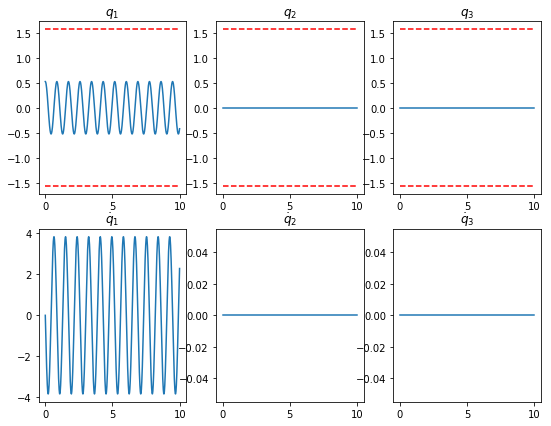

In [41]:
fig1 = swing_plot(t, sol1)
plt.show(fig1)

The first order natural frequency is 1.15 Hz which is consistent with the experiment.

In [26]:
anim = swing_animation(sol1, myParam)
HTML(anim.to_html5_video())

In [44]:
# constraint test
# open loop state update function
def f(y, t):
    v = y[3:]
    if t < 5:
        tau = np.ones(2) * 100
    else:
        tau = np.ones(2) * -100
    
    a = ddq_np(y, tau, myParam, myCon).squeeze()
    return np.r_[v, a]

sol2 = odeint(f, y0, t)

In [66]:
def b(t):
    if int(t) %2 < 1:
        tau = np.ones(2) * 100
    else:
        tau = np.ones(2) * -100
    return tau

def foo(y, t, control):
    v = y[3:]
    # v = np.clip(v, -np.pi * 4 * np.ones_like(v), np.pi * 4 * np.ones_like(v))
    tau = b(t)
    a = ddq_np(y, tau, myParam, myCon).squeeze()
    return np.r_[v, a]
sol2 = odeint(f, y0, t)

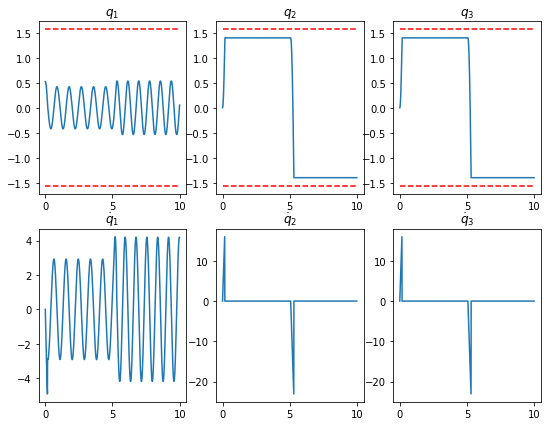

In [67]:
fig2 = swing_plot(t, sol2)
plt.show(fig2)

In [29]:
anim = swing_animation(sol2, myParam)
HTML(anim.to_html5_video())

It turns out the swing moves up a little somehow

# Utils

In [29]:
def kinematic(y, param):
    p1_ = p1_np(y ,param).squeeze()
    p2_ = p2_np(y, param).squeeze()
    p3_ = p3_np(y, param).squeeze()
    p21_= p21_np(y, param).squeeze()
    p31_= p31_np(y, param).squeeze()
    return (p1_, p2_, p3_, p21_, p31_)

def swing_plot(t, sol):
    fig, axes = plt.subplots(2, 3, figsize=(9, 7))
    axes = axes.ravel()
    for i, ax in enumerate(axes):
        ax.plot(t, sol[:, i])
        if i < 3:
            ax.plot([t[0], t[-1]], [ np.pi/2, np.pi/2], 'r--')
            ax.plot([t[0], t[-1]], [-np.pi/2,-np.pi/2], 'r--')
            ax.set_title('$q_{}$'.format(i+1))
        else:
            ax.set_title('$\dot{q}_' + '{}$'.format(i-2))
    return fig

def swing_animation(sol, param0):
    fig, ax = plt.subplots(figsize=(6, 6))
    plt.axis('equal')
    plt.axis([-0.3, 0.3, -0.3, 0.3])

    line1, = ax.plot([], [], lw=1, color='k', linestyle='-', marker='o', ms=5)
    line2, = ax.plot([], [], lw=2, color='b', linestyle='-', marker='o', ms=3)

    def init():
        line1.set_data([], [])
        line2.set_data([], [])
        return (line1, line2)

    def animate(i):
        y = sol[i, :]
        p1, p2, p3, p21, p31 = kinematic(sol[i, :], param0)
        line1.set_data([0, p1[0]], [0, p1[1]])
        line2.set_data([p21[0], p2[0], p3[0], p31[0]], [p21[1], p2[1], p3[1], p31[1]])
        return (line1,line2)
    # call the animator. blit=True means only re-draw the parts that have changed.
    anim = animation.FuncAnimation(fig, animate, init_func=init,
                                   frames=1000, interval=10, blit=True)
    return anim

In [ ]:
def f_(t, y, tau, param, con):
    v = y[3:]
    a = ddq_np(y, tau, param, con).squeeze()
    return np.r_[v, a]

In [ ]:
import cloudpickle
cloudpickle.dump(f_, open('./model/swing_dynamic.dll', 'wb'))
cloudpickle.dump(kinematic, open('./model/swing_kinematic.dll', 'wb'))